## This notebook turns an audio MP3 into a video of a brain moving to the beat. 

Notebook was created using a clip from the song Mystery of Love (Mr Fingers, 1985)

Steps:

1) Loads MP3 file and converts to spectrogram

2) Hi-pass filters the audio to reduce spectrogram to beat information

3) Reduces the spectrogram to 20 features (to match latent space of the trained VAE model)

4) Creates an image using the trained VAE model using the 20 features from the spectrogram frequency bins for each timepoint

5) Merges the images into a GIF

6) Merges the GIF and audio into an MP4 video


In [13]:
## pip installs
#!pip install librosa
#!pip install torch
#!pip install imageio-ffmpeg

In [347]:
# Setup
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os
import torch
import torch.nn as nn
from IPython.display import display, HTML
from IPython.display import display, Image
from sklearn.preprocessing import minmax_scale
from moviepy.editor import VideoFileClip, AudioFileClip

In [ ]:
# Setup paths here

# Audio MP3 path (example: r"C:\Users\foo\Documents\GroovyBrain\files\audio_clip.mp3")
file_path = r""

# Temporary GIF path (example: r"C:\Users\foo\Documents\GroovyBrain\files\temp_gif.gif")
output_gif_path = r""

# Final video path (example: r"C:\Users\foo\Documents\GroovyBrain\files\GroovyBrain_video.mp4")
output_video_path = r""

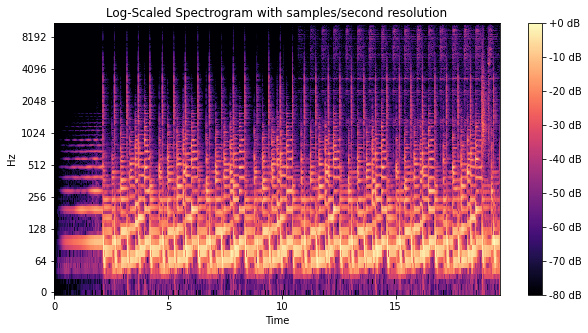

In [333]:
# Load audio file (provide the file path here)
y, sr = librosa.load(file_path)

# Set frames per second to align audio and video throughout
FPS = 24

# Set the desired temporal resolution
target_fps = FPS
hop_length = sr // target_fps

# Create a spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)), ref=np.max)

# Plot the log-scaled spectrogram
plt.figure(figsize=(10, 5))
librosa.display.specshow(D, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Scaled Spectrogram with samples/second resolution')
plt.show()

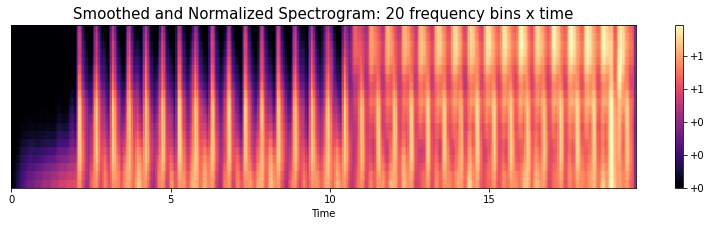

(20, 471)


In [334]:
# Set the desired parameters for the low frequency region Mel spectrogram
bl_fmin = 1000
num_bins = 20
bl_n_fft = 4096
hop_length = sr // FPS  # Adjusted hop length for samples per second resolution (according to FPS)

# Compute the high frequency region Melodic spectrogram
S_bl = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=bl_n_fft,
                                       hop_length=hop_length,
                                       fmin=bl_fmin, 
                                       n_mels=num_bins)

# Convert to dB scale
S_bl_db = librosa.power_to_db(S_bl, ref=np.max)

# Normalize each frequency band in S_bl_db to be between 0 and 1 across time
S_bl_db_normalized = minmax_scale(S_bl_db, axis=1)

# Smooth across time with a 150ms kernel
smooth_window_time = int(0.15 * sr / hop_length)  # Convert 150ms to frames
S_bl_db_normalized_smoothed_time = np.zeros_like(S_bl_db_normalized)
for i in range(num_bins):
    S_bl_db_normalized_smoothed_time[i] = np.convolve(S_bl_db_normalized[i], np.ones(smooth_window_time) / smooth_window_time, mode='same')

# Smooth across frequency bins with a 3 window
smooth_window_freq = 3
S_bl_db_normalized_smoothed = np.zeros_like(S_bl_db_normalized_smoothed_time)
for t in range(S_bl_db_normalized_smoothed_time.shape[1]):
    for i in range(num_bins):
        start = max(i - smooth_window_freq // 2, 0)
        end = min(i + smooth_window_freq // 2 + 1, num_bins)
        S_bl_db_normalized_smoothed[i, t] = np.mean(S_bl_db_normalized_smoothed_time[start:end, t])

# Plot the smoothed and normalized spectrogram 
plt.figure(figsize=(14, 3))
librosa.display.specshow(S_bl_db_normalized_smoothed, sr=sr, hop_length=hop_length, x_axis='time', y_axis='off')
plt.title('Smoothed and Normalized Spectrogram: 20 frequency bins x time', fontsize=15)
plt.colorbar(format='%+2.0f')
plt.show()

# Print shape of spectrogram which will be used to create images (features x time samples)
print(S_bl_db_normalized_smoothed.shape)

In [335]:
# Input for the VAE model
input_spectrogram = S_bl_db_normalized_smoothed

In [340]:
# Convert NumPy array to torch tensor
tensor_temp = torch.tensor(input_spectrogram)
tensor_spectrogram = torch.transpose(tensor_temp, 0, 1)

In [341]:
# Setup the VAE model
class VariationalAutoEncoder(nn.Module):
    def __init__(self, z_dim):
        super(VariationalAutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 32x32 output
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 16x16 output
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 8x8 output
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 4x4 output
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256*4*4, 512),
            nn.ReLU()
        )

        # Latent space
        self.fc_mu = nn.Linear(512, z_dim)
        self.fc_logvar = nn.Linear(512, z_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 output
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 output
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32 output
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 64x64 output
            nn.Sigmoid()  # Sigmoid to get pixel values between 0 and 1
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var


In [342]:
# Define your VAE model
z_dim = 20  # Dimension of latent space
vae = VariationalAutoEncoder(z_dim)

# Trained model path
trained_model_path = r"C:\Users\judel\Documents\GroovyBrain\trained_model\groovy_brain_trained_vae.pth"

# Load the trained model weights
vae.load_state_dict(torch.load(trained_model_path))

# Ensure the model is in evaluation mode
vae.eval()

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=4096, out_features=512, bias=True)
    (10): ReLU()
  )
  (fc_mu): Linear(in_features=512, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4096, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(256, 4, 4))
    (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6

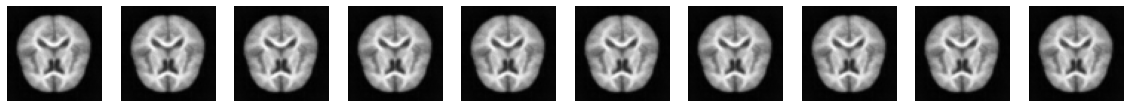

In [346]:
# Generate and plot the images for the first ten time samples

vae.eval()  # Switch to evaluation mode
with torch.no_grad():
    # Get the device where the decoder's parameters are located
    device = next(vae.decoder.parameters()).device
    # Convert the input tensor to the same data type as the decoder's parameters
    tensor_spectrogram = tensor_spectrogram.to(device=device, dtype=vae.decoder[0].weight.dtype)
    generated_images = vae.decode(tensor_spectrogram)

# Plot the generated images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')

plt.show()

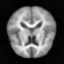

In [348]:
# Create a GIF with all the generated images
tensor = generated_images

# Reshape the tensor
nsamples, _, height, width = tensor.shape
tensor_reshaped = tensor.reshape(nsamples, height, width)

# Save each sample as an image
image_paths = []
for i in range(nsamples):
    image_path = f"sample_{i}.png"
    plt.imsave(image_path, tensor_reshaped[i], cmap='gray')  # Adjust cmap if not grayscale
    image_paths.append(image_path)

# Create a GIF from the images
with imageio.get_writer(output_gif_path, mode='I', duration=1/24) as writer:
    for image_path in image_paths:
        image = imageio.imread(image_path)
        writer.append_data(image)

# Delete the temporary image files
for image_path in image_paths:
    os.remove(image_path)

# Display the GIF
display(Image(filename=output_gif_path))


In [319]:
# Combine GIF and audio to make MP4 video

# Load the GIF and the audio file
gif_clip = VideoFileClip(output_gif_path)
audio_clip = AudioFileClip(file_path)

# Calculate the difference in start time between the GIF and the audio
start_time_difference = gif_clip.start - audio_clip.start

# Shift the start time of the GIF to align with the audio
gif_clip = gif_clip.set_start(gif_clip.start - start_time_difference)

# Set the duration of the GIF to match the audio duration
gif_clip = gif_clip.set_duration(audio_clip.duration)

# Combine the GIF and the audio
video_clip = gif_clip.set_audio(audio_clip)

# Write the merged video file
video_clip.write_videofile(output_video_path, codec='libx264', audio_codec='aac')

# Close the clips
gif_clip.close()
audio_clip.close()

Moviepy - Building video C:\Users\judel\Documents\GroovyBrain\video\aligned_video.mp4.
MoviePy - Writing audio in aligned_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\judel\Documents\GroovyBrain\video\aligned_video.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\judel\Documents\GroovyBrain\video\aligned_video.mp4
